In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.data_handler import DataHandler
from src.additional_analysis_logic import autocorrelation_fit
from src.analysis_logic import FitMethods

plt.style.use('seaborn')
plt.rcParams['image.cmap'] = sns.color_palette("mako", as_cmap=True)

# Membrane Sample

In [ ]:
membrane = DataHandler(measurement_folder="20211025_UHVTesting_MembraneSample")
membrane_measurements = membrane.load_measurement_list_into_dataclass_list([
    r"Confocal\20211027-0940-45__confocal_xy_image_1_fig",
    r"Counter\20211026-1621-55_count_trace"
])

In [ ]:
confocal = membrane_measurements[0]
fig, ax = plt.subplots(figsize=(6, 4))

extent = np.array([confocal.params['X image min (m)'], confocal.params['X image max (m)'], confocal.params['Y image min'], confocal.params['Y image max']]) * 1e6
img = ax.imshow(confocal.data / 1e6, origin="lower", extent=extent)
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Fluorescence (Mc/s)")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")
ax.grid(False)
    
membrane.save_figures(fig, filename="20211027-0940-45__confocal_xy_image_1")

# Tip 3E7

In [ ]:
tip_3E7 = DataHandler(measurement_folder="20220222_FR0612-3E7_RT")
tip_3E7_measurements = tip_3E7.load_measurement_list_into_dataclass_list([r"Confocal\20220223-1215-56_tip_1_confocal_xy_image_1_fig"])

## Confocal

In [ ]:
confocal = tip_3E7_measurements[0]

fig, ax = plt.subplots(figsize=(3, 4))

extent = np.array([confocal.params['X image min (m)'], confocal.params['X image max (m)'], confocal.params['Y image min'], confocal.params['Y image max']]) * 1e6
img = ax.imshow(confocal.data / 1e3, origin="lower", extent=extent)
#cbar = fig.colorbar(img, ax=ax)
#cbar.set_label("Fluorescence (kc/s)")
#ax.set_xlabel("X (μm)")
#ax.set_ylabel("Y (μm)")
ax.grid(False)

ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
tip_3E7.save_figures(fig, filename=confocal.filename)

# Tip 3P16

In [3]:
tip_3P16 = DataHandler(measurement_folder="20220304_FR0612-F2-3P16")
tip_3P16_measurements = tip_3P16.load_measurement_list_into_dataclass_list([
        r"PulsedMeasurement\20220316-1434-53_rabi_broken_cable_22dBm_pulsed_measurement",
        r"PulsedMeasurement\20220316-1545-42_ramsey_broken_cable_22dBm_pulsed_measurement_fig",
        r"Counter\20220316-2219-26_count_trace_fig",
        r"Counter\20220316-2246-44_count_trace_background_fig",
        r"PulsedMeasurement\20220315-2050-39_odmr_22dBm_600ns_pulsed_measurement_fig",
        r"PulsedMeasurement\20220316-2214-59_rabi_twopoint_raw_timetrace"
    ]
)

src.path_handler :: INFO :: Data folder path is \\kernix\qudiamond\Data\20220304_FR0612-F2-3P16
src.path_handler :: INFO :: Figure folder path is C:/Nextcloud\Data_Analysis\20220304_FR0612-F2-3P16


## Rabi

In [ ]:
rabi = tip_3P16_measurements[0]

fig, ax = plt.subplots(figsize=(5, 3))
x = rabi.pulsed.measurement.data["Controlled variable(s)"] * 1e9
y, yerr = rabi.analysis.analyse_mean_norm(rabi.pulsed.laser_pulses.data, signal_start=150e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
ax.errorbar(x, y, yerr=yerr, fmt=".", capsize=3, markeredgewidth=1)

fit_x, fit_y, result = rabi.analysis.perform_fit(x=x, y=y, fit_function="sinestretchedexponentialdecay")
ax.plot(fit_x, fit_y)
ax.set_xlabel(r"$\tau_{RF}$ (ns)")
ax.set_ylabel("$P (m_s = 0)$")
ax.set_title(r"$T_{1\rho} \approx $" + f"{round(result.values['lifetime'] / 1e3)} μs")

tip_3P16.save_figures(fig, filename=rabi.filename)

## Ramsey

In [ ]:
ramsey = tip_3P16_measurements[1]

fig, ax = plt.subplots(figsize=(5, 3))
x = ramsey.data["Controlled variable(s)"] * 1e6
y1, y1err = ramsey.data["Signal"], ramsey.data["Error"]
y2, y2err = ramsey.data["Signal2"], ramsey.data["Error2"]

y_diff =  y1 - y2
y_differr = np.sqrt(np.square(y1err) + np.square(y2err))
ax.errorbar(x, y_diff, yerr=y_differr, fmt="o", capsize=4, markeredgewidth=1)
fit_x, fit_y, result = ramsey.analysis.perform_fit(x=x, y=y_diff, fit_function=FitMethods.sinedoublewithexpdecay)

ax.plot(fit_x, fit_y)
ax.set_xlabel(r"$\tau$ (μs)")
ax.set_ylabel(r"$\Delta \left( \hat{P} \left( \frac{\pi}{2} \right) - \hat{P} \left( \frac{3\pi}{2} \right) \right)$")
#ax.errorbar(x, y2, yerr=y2err, fmt="o-", capsize=4, markeredgewidth=1)
ax.set_title(r"$T_2^* \approx $" + f"{round(result.values['lifetime'])} μs")
tip_3P16.save_figures(fig, filename=ramsey.filename)

## Timetrace

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex="all", figsize=(5, 3))
titles = ["NV", "Background"]

for idx, counter in enumerate(tip_3P16_measurements[2:4]):
    if idx == 0:
        # Roughly match total time of measurement window
        x, y = counter.data["Time (s)"][:len(counter.data)//2], counter.data["Signal0 (counts/s)"][:len(counter.data)//2] / 1e3
    else:
        x, y = counter.data["Time (s)"], counter.data["Signal0 (counts/s)"] / 1e3
    ax[idx].plot(x, y)
    ax[idx].plot(x, savgol_filter(y, 21, 1))
    ax[idx].set_title(titles[idx])
        
ax[-1].set_xlabel("Time (s)")
fig.supylabel("Fluorescence (kc/s)")

tip_3P16.save_figures(fig, filename="timetrace_vs_background")

## ODMR

In [ ]:
odmr = tip_3P16_measurements[4]
fig, ax = plt.subplots(figsize=(5, 3))
x = odmr.data["Controlled variable(Hz)"] / 1e9
y, yerr = odmr.analysis.analyse_mean_norm(odmr.pulsed.laser_pulses.data, signal_start=100e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)

ax.errorbar(x, y, yerr=yerr, fmt=".", capsize=3, markeredgewidth=1)
fit_x, fit_y, result = odmr.analysis.perform_fit(x=x, y=y, fit_function="lorentziandouble", estimator="dip")
ax.plot(fit_x, fit_y)

ax.set_xlabel(r"$\omega_{RF}$ (GHz)")
ax.set_ylabel("$P (m_s = 0)$")

tip_3P16.save_figures(fig, filename=odmr.filename)

# Tip 3B4

In [ ]:
tip_3B4 = DataHandler(measurement_folder="20220330_FR0612-F2-3B4")
tip_3B4_measurements = tip_3B4.load_measurement_list_into_dataclass_list([
        r"Confocal\20220404-1557-16_full_image_after_bonding_confocal_xy_image_1_fig",
        r"Confocal\20220405-1004-19_overnight_focusing_confocal_xy_image_1_fig",
        r"Autocorrelation\20220330-1617-38_autocorrelation_fig",
        r"frq-sweep-akiyama002",
    ]
)

## Confocal

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 4))

ylims = [[42, 52], [49, 57]]
xlims = [[44, 54], [53, 61]]
titles = ["Day 0", "Day 1"]

for idx, confocal in enumerate(tip_3B4_measurements[0:2]):
    extent = np.array([confocal.params['X image min (m)'], confocal.params['X image max (m)'], confocal.params['Y image min'], confocal.params['Y image max']]) * 1e6
    ax[idx].grid(False)
    img = ax[idx].imshow(confocal.data / 1e3, origin="lower", extent=extent)
    ax[idx].set_xlabel("X (μm)")
    ax[idx].set_ylabel("Y (μm)")
    ax[idx].set_ylim(ylims[idx])
    ax[idx].set_xlim(xlims[idx])
    # ax[idx].set_title(confocal.timestamp.strftime("%B %d, %Y"))
    ax[idx].set_title(titles[idx])

fig.tight_layout()
tip_3B4.save_figures(fig, filename="confocal_comparison")

## Autocorrelation

In [ ]:
autocorr = tip_3B4_measurements[2]

x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

fig, ax = plt.subplots()
ax.plot(x, y, "o")

fit_x, fit_y, result = autocorrelation_fit(x, y)
ax.plot(fit_x, fit_y)

ax.set_title(f"$g^{(2)}(0) = ${round(result['g2_0'], 2)}")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("$g^{(2)}(t)$")

## AFM

In [ ]:
afm = tip_3B4_measurements[3]

x = afm.data["Frequency Shift (Hz)"] / 1e3
center_freq = afm.params["Center Frequency (Hz)"] / 1e3

amplitude = afm.data["Amplitude (m)"] * 1e9
phase = afm.data["Phase (deg)"]

fig, (ax, ax1) = plt.subplots(nrows=2, sharex="all", figsize=(5, 3))

ax.plot(x + center_freq, amplitude)
ax.set_ylabel("Amplitude (nm)")
ax1.plot(x + center_freq, phase)
ax1.set_ylabel("Phase (deg)")

ax1.set_xlabel("Frequency (kHz)")

resonance_freq = tip_3B4_measurements[3].params["f_res (Hz)"] / 1e3
ax.axvline(resonance_freq, linestyle="--", color="C2")
ax1.axvline(resonance_freq, linestyle="--", color="C2")

ax.set_title(f"Q-factor = {int(afm.params['Q'])}")

tip_3B4.save_figures(fig, filename=afm.filename)

# Tip 3C2 - RT vs UHV

In [63]:
tip_3C2 = DataHandler(measurement_folder="20220405_FR0612-F2-3C2")
tip_3C2_measurements = tip_3C2.load_measurement_list_into_dataclass_list([
        r"Autocorrelation\20220414-1352-12_autocorrelation_fig",
        r"PulsedMeasurement\20220420-1039-44_t1_25ms_pulsed_measurement_fig"
    ]
)

src.path_handler :: INFO :: Data folder path is \\kernix\qudiamond\Data\20220405_FR0612-F2-3C2
src.path_handler :: INFO :: Figure folder path is C:/Nextcloud\Data_Analysis\20220405_FR0612-F2-3C2


In [64]:
tip_3C2_uhv = DataHandler(measurement_folder="20220505_FR0612-F2-3B6_uhv")
tip_3C2_uhv_measurements = tip_3C2_uhv.load_measurement_list_into_dataclass_list([
        r"Confocal\20220506-2113-21__confocal_xy_image_1_fig",
        r"Counter\20220506-1425-39_count_trace_fig",
        r"Autocorrelation\20220506-2058-44_autocorrelation_fig",
        r"PulsedMeasurement\20220515-2324-45_t1_6ms_pulsed_measurement_fig"
    ]
)

src.path_handler :: INFO :: Data folder path is \\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv
src.path_handler :: INFO :: Figure folder path is C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv


## Autocorrelation

Text(0.5, 0, 'Time (ns)')

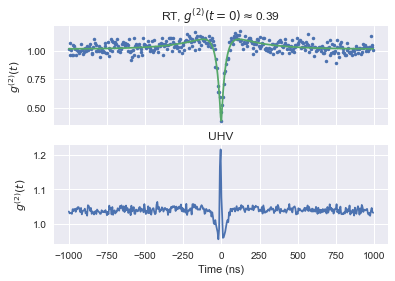

In [87]:
autocorr = tip_3C2_measurements[0]

fig, (ax, ax1) = plt.subplots(nrows=2, sharex="all", figsize=(6, 4))

x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax.plot(x, y, ".")

ax.set_ylabel("$g^{(2)}(t)$")
ax.set_title("RT")

fit_x, fit_y, result = autocorrelation_fit(x, y)
ax.plot(fit_x, fit_y)

ax.set_title(r"RT, $g^{(2)}(t = 0) \approx $" + f"{round(result['g2_0'], 2)}")

autocorr = tip_3C2_uhv_measurements[2]
x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax1.plot(x, y, "-")
ax1.set_title("UHV")
ax1.set_ylabel("$g^{(2)}(t)$")
ax1.set_xlabel("Time (ns)")

# tip_3C2_uhv.save_figures(fig, filename="autocorr_rt_uhv_comparison")

## T1

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(5, 4))

t1 = tip_3C2_measurements[1]

x = t1.data["Controlled variable(s)"] * 1e3
y, yerr = t1.analysis.analyse_mean_norm(t1.pulsed.laser_pulses.data, signal_start=150e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=4, markeredgewidth=1)

fit_x, fit_y, result = t1.analysis.perform_fit(x=x, y=y, fit_function="decayexponential")
ax.plot(fit_x, fit_y)
ax.set_title(f"RT, $T_1 ≈ {int(result.params['lifetime'].value)}$ ms")
ax.set_ylabel("$P (m_s = 0)$")

t1 = tip_3C2_uhv_measurements[3]

x = t1.data["Controlled variable(s)"] * 1e3

y, yerr = t1.analysis.analyse_mean_norm(t1.pulsed.laser_pulses.data, signal_start=150e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
ax1.errorbar(x, y, yerr=yerr, fmt="o", capsize=4, markeredgewidth=1)

ax1.set_title(f"UHV")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("$P (m_s = 0)$")

fig.tight_layout()
tip_3C2_uhv.save_figures(fig, filename="t1_rt_uhv_comparison")

# Tip 3C2 - UHV

## Confocal

In [ ]:
confocal = tip_3C2_uhv_measurements[0]

fig, ax = plt.subplots(figsize=(5, 3))

extent = np.array([confocal.params['X image min (m)'], confocal.params['X image max (m)'], confocal.params['Y image min'], confocal.params['Y image max']]) * 1e3
img = ax.imshow(confocal.data / 1e3, origin="lower", extent=extent)
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Fluorescence (kc/s)")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")
ax.grid(False)
ax.set_ylim([2, 8])
ax.set_xlim([1, 8])

fig.tight_layout()

tip_3C2_uhv.save_figures(fig, filename=confocal.filename)

## Timetrace

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

counter = tip_3C2_uhv_measurements[1]
x, y = counter.data["Time (s)"], counter.data["Signal0 (counts/s)"] / 1e3
ax.plot(x, y)
ax.plot(x, savgol_filter(y, 21, 1))

ax.set_ylabel("Fluorescence (kc/s)")
ax.set_xlabel("Time (s)")
    
fig.tight_layout()

tip_3C2_uhv.save_figures(fig, filename=counter.filename)

# Tip 3G6

In [ ]:
tip_3G6 = DataHandler(measurement_folder="20220405_FR0612-F2-3G6")
tip_3G6_measurements = tip_3G6.load_measurement_list_into_dataclass_list([
        r"Autocorrelation\20220412-1229-18_150kcps_autocorrelation_fig",
        r"Confocal\20220405-1244-03_first_approach_confocal_xy_image_1_fig",
        r"Confocal\20220407-1111-24_after_bonding_confocal_xy_image_1_fig",
        r"Confocal\20220412-1315-44_nv_disappered_confocal_xy_image_1_fig",
        "frq-sweep-qnami-after-bonding001"
    ]
)

## Autocorrelation

In [ ]:
autocorr = tip_3G6_measurements[0]

fig, ax = plt.subplots()

x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax.plot(x, y, "-")

ax.set_ylabel("$g^{(2)}(t)$")

fit_x, fit_y, result = autocorrelation_fit(x, y)
ax.plot(fit_x, fit_y)

ax.set_title(f"$g^{(2)}(0)$ = {round(result['g2_0'], 2)}")

## Confocal

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 8))

for idx, confocal in enumerate(tip_3G6_measurements[1:4]):
    extent = np.array([confocal.params['X image min (m)'], confocal.params['X image max (m)'], confocal.params['Y image min'], confocal.params['Y image max']]) * 1e6
    ax[idx].grid(False)
    img = ax[idx].imshow(confocal.data / 1e3, cmap="viridis", origin="lower", extent=extent)
    ax[idx].set_xlabel("X (μm)")
    ax[idx].set_ylabel("Y (μm)")
    ax[idx].set_title(confocal.timestamp.strftime("%B %d, %Y"))
    
fig.tight_layout()

## AFM

In [ ]:
afm = tip_3G6_measurements[4]

x = afm.data["Frequency Shift (Hz)"] / 1e3
center_freq = afm.params["Center Frequency (Hz)"] / 1e3

amplitude = afm.data["Amplitude (m)"] * 1e9
phase = afm.data["Phase (deg)"]

fig, (ax, ax1) = plt.subplots(nrows=2, sharex="all")

ax.plot(x + center_freq, amplitude)
ax.set_ylabel("Amplitude (nm)")
ax1.plot(x + center_freq, phase)
ax1.set_ylabel("Phase (deg)")

ax1.set_xlabel("Frequency (kHz)")

resonance_freq = afm.params["f_res (Hz)"] / 1e3
ax.axvline(resonance_freq, linestyle="--", color="C2")
ax1.axvline(resonance_freq, linestyle="--", color="C2")

ax.set_title(f"Q-factor = {int(afm.params['Q'])}")

# Tip 3B6 and Tip 3C2 - RT vs UHV

In [2]:
tip_3B6_uhv = DataHandler(measurement_folder="20220505_FR0612-F2-3B6_uhv")
tip_3B6_uhv_measurements = tip_3B6_uhv.load_measurement_list_into_dataclass_list([
        r"Autocorrelation\20220518-1738-57_right_spot_10mW_autocorrelation_fig",
        r"PulsedMeasurement\20220518-1017-50_t1_high_pressure_1ms_pulsed_measurement_fig",
        r"PulsedMeasurement\20220513-1636-28_t1_6ms_pulsed_measurement",
        r"PulsedMeasurement\20220519-1058-48_t1_high_pressure_two_point_5ms_pulsed_measurement_fig"
    ]
)

src.path_handler :: INFO :: Data folder path is \\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv
src.path_handler :: INFO :: Figure folder path is C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv


## Autocorrelation

src.data_handler :: INFO :: Saving 'autocorr_rt_uhv_comparison' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'
src.data_handler :: INFO :: Saving 'autocorr_comparision_across_tips_rt_and_uhv' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'


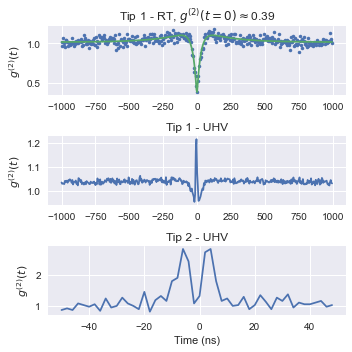

In [98]:
autocorr = tip_3C2_measurements[0]

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(5, 5))

x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax.plot(x, y, ".")

ax.set_ylabel("$g^{(2)}(t)$")

fit_x, fit_y, result = autocorrelation_fit(x, y)
ax.plot(fit_x, fit_y)

ax.set_title(r"Tip 1 - RT, $g^{(2)}(t = 0) \approx $" + f"{round(result['g2_0'], 2)}")

autocorr = tip_3C2_uhv_measurements[2]
x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax1.plot(x, y, "-")
ax1.set_title("Tip 1 - UHV")
ax1.set_ylabel("$g^{(2)}(t)$")

tip_3C2_uhv.save_figures(fig, filename="autocorr_rt_uhv_comparison")

autocorr = tip_3B6_uhv_measurements[0]

x = autocorr.data["Time (ps)"] / 1e3
y = autocorr.data["g2(t) norm"]

ax2.plot(x, y, "-")
ax2.set_title("Tip 2 - UHV")
ax2.set_ylabel("$g^{(2)}(t)$")
ax2.set_xlabel("Time (ns)")

fig.tight_layout()
tip_3B6_uhv.save_figures(fig, filename="autocorr_comparision_across_tips_rt_and_uhv")

## T1

src.data_handler :: INFO :: Saving 't1_tip_comparision_rt_and_uhv' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'


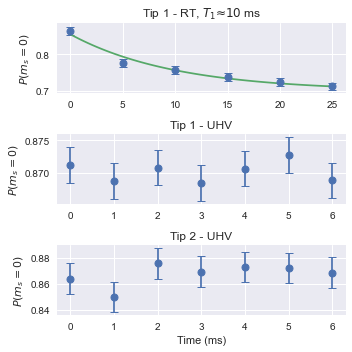

In [99]:
fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(5, 5))

t1 = tip_3C2_measurements[1]

x = t1.data["Controlled variable(s)"] * 1e3
y, yerr = t1.analysis.analyse_mean_norm(t1.pulsed.laser_pulses.data, signal_start=130e-9, signal_end=300e-9, norm_start=1000e-9, norm_end=2000e-9)
ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=4, markeredgewidth=1)

fit_x, fit_y, result = t1.analysis.perform_fit(x=x, y=y, fit_function="decayexponential")
ax.plot(fit_x, fit_y)
ax.set_title(f"Tip 1 - RT, $T_1 ≈ {int(result.params['lifetime'].value)}$ ms")
ax.set_ylabel("$P (m_s = 0)$")

t1 = tip_3C2_uhv_measurements[3]

x = t1.data["Controlled variable(s)"] * 1e3

y, yerr = t1.analysis.analyse_mean_norm(t1.pulsed.laser_pulses.data, signal_start=130e-9, signal_end=300e-9, norm_start=1000e-9, norm_end=2000e-9)
ax1.errorbar(x, y, yerr=yerr, fmt="o", capsize=4, markeredgewidth=1)

ax1.set_title(f"Tip 1 - UHV")
ax1.set_ylabel("$P (m_s = 0)$")


t1 = tip_3B6_uhv_measurements[2]

x = t1.data["Controlled variable(s)"] * 1e3
y, yerr = t1.analysis.analyse_mean_norm(t1.pulsed.laser_pulses.data, signal_start=130e-9, signal_end=300e-9, norm_start=1000e-9, norm_end=2000e-9)
ax2.errorbar(x, y, yerr=yerr, fmt="o", capsize=4, markeredgewidth=1)

ax2.set_title(f"Tip 2 - UHV")
ax2.set_ylabel("$P (m_s = 0)$")
ax2.set_xlabel("Time (ms)")

fig.tight_layout()

tip_3B6_uhv.save_figures(fig, filename="t1_tip_comparision_rt_and_uhv")

## Two point comparison

src.data_handler :: INFO :: Saving 'timetrace_rt_uhv_comparison' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'


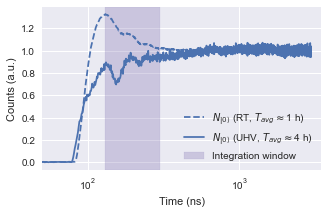

In [84]:
two_point_uhv = tip_3B6_uhv_measurements[1]
two_point_rt = tip_3P16_measurements[5]

fig, ax = plt.subplots(figsize=(5, 3))

rt_trace = two_point_rt.pulsed.laser_pulses.data[0]
rt_avg_time = two_point_rt.params['Approx. measurement time (s)'] / two_point_rt.params['Number of laser pulses']
ax.plot(rt_trace / np.mean(rt_trace[2000:]), label=r"$N_{|0\rangle}$ (RT, $T_{avg} \approx $" + f"{round(rt_avg_time / 3600)} h)", linestyle="--")

uhv_trace = two_point_uhv.pulsed.laser_pulses.data[0]
uhv_avg_time = two_point_uhv.params['Approx. measurement time (s)'] / two_point_uhv.params['Number of laser pulses']
ax.plot(uhv_trace / np.mean(uhv_trace[2000:]), label=r"$N_{|0\rangle}$ (UHV, $T_{avg} \approx $" + f"{round(uhv_avg_time / 3600)} h)", color="C0")

ax.set_xscale("log")
ax.set_xlim([50, 3500])
ax.set_ylabel("Counts (a.u.)")
ax.set_xlabel("Time (ns)")

ax.axvspan(130, 300, alpha=0.3, label="Integration window", color="C3")

ax.legend()

tip_3B6_uhv.save_figures(fig, filename="timetrace_rt_uhv_comparison")

src.data_handler :: INFO :: Saving 'timetrace_comparison' to 'C:/Nextcloud\Data_Analysis\20220304_FR0612-F2-3P16'


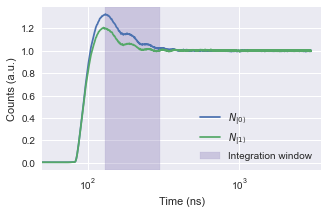

In [86]:
fig, ax = plt.subplots(figsize=(5, 3))

rt_trace_0 = two_point_rt.pulsed.laser_pulses.data[0]
rt_trace_1 = two_point_rt.pulsed.laser_pulses.data[1]

ax.plot(rt_trace_0 / np.mean(rt_trace_0[2000:]), label=r"$N_{|0\rangle}$")
ax.plot(rt_trace_1 / np.mean(rt_trace_1[2000:]), label=r"$N_{|1\rangle}$")

ax.set_ylabel("Counts (a.u.)")
ax.set_xscale("log")
ax.set_xlim([50, 3500])
ax.set_xlabel("Time (ns)")

ax.axvspan(130, 300, alpha=0.3, label="Integration window", color="C3")

ax.legend()

tip_3P16.save_figures(fig, filename="timetrace_comparison")